# Исследование методов оптимизации для НС

## Описание задания:
Реализовать некоторые методы оптимизации: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на визуальном примере, а также при обучении сверточной нейронной сети на датасете MNIST.


In [80]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [81]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

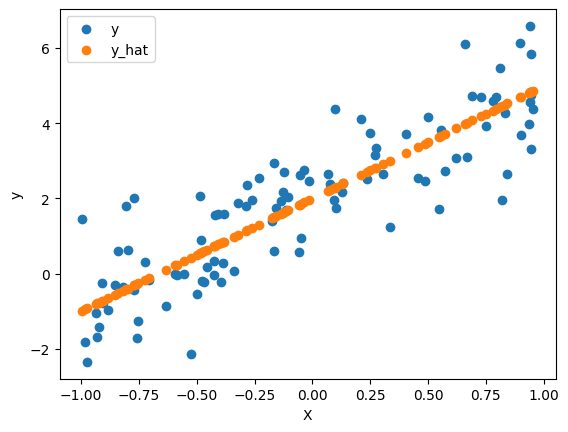

In [82]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

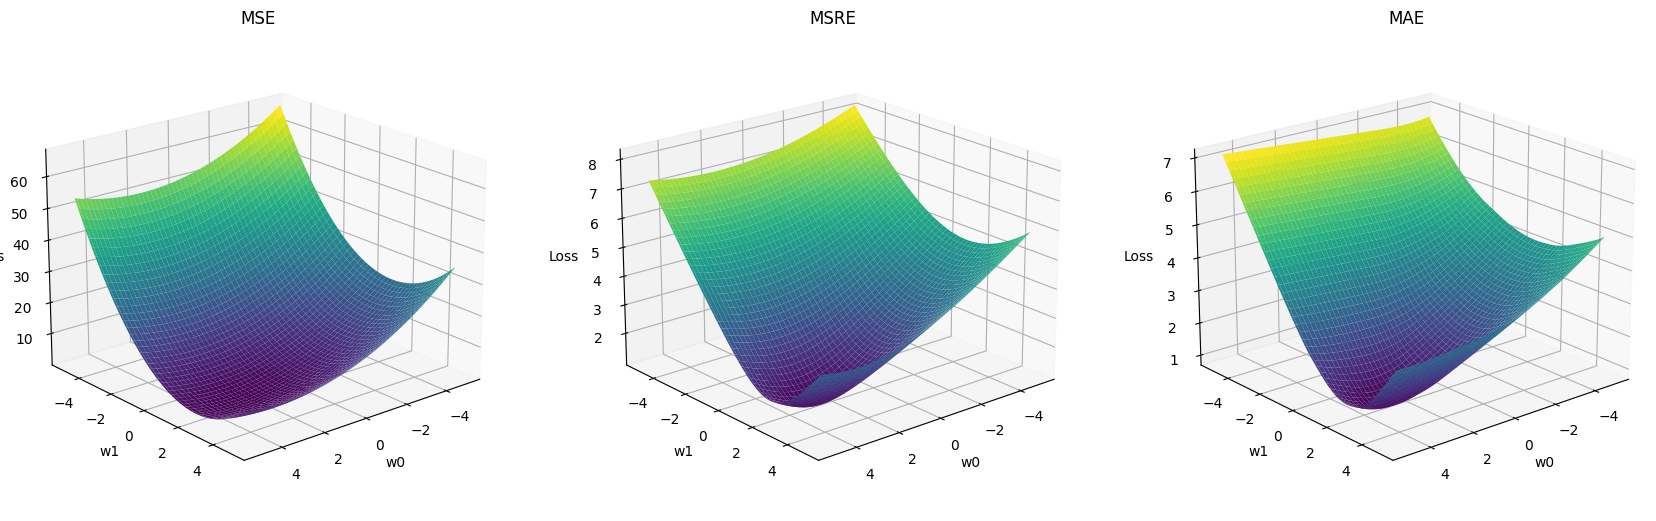

In [83]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [84]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [85]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [86]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [87]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


In [88]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] += p.grad ** 2
                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализация методов Momentum, AdaDelta, Adam

#### Momentum
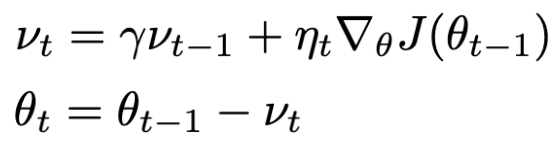

In [89]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)

        self.lr = lr
        self.gamma = gamma
        self.velocity = [torch.zeros_like(p) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                prev_velocity = self.velocity[i]
                self.velocity[i] = prev_velocity * self.gamma + self.lr * p.grad
                p -= self.velocity[i]




#### AdaDelta
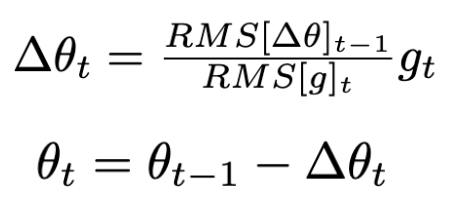

In [108]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma

        self.theta_cached = [torch.ones_like(p) for p in self.params] #not-null values init
        self.G = [torch.zeros_like(p) for p in self.params]
        self.dtheta = [torch.zeros_like(p) for p in self.params]



    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.theta_cached[i] = self.gamma * self.theta_cached[i] + (1-self.gamma) * (torch.square(self.dtheta[i]))
                self.G[i] = self.gamma * self.G[i] + (1-self.gamma) * torch.square(p.grad)
                self.dtheta[i] = - (self.theta_cached[i].sqrt() * p.grad) / (self.G[i].sqrt() +self.eta)


                p += self.dtheta[i]

#### Adam
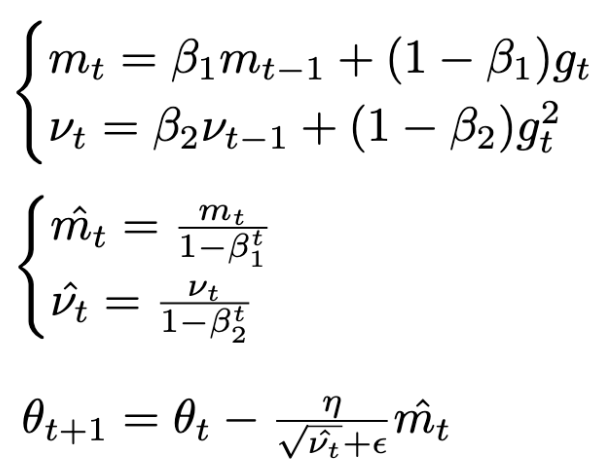

In [107]:
class Adam(Optimizer):
    def __init__(self, params, lr  = 1e-2, eta= 1e-8, b1 =0.9, b2 = 0.999):
        super().__init__(params)
        self.lr = lr
        self.eta = eta
        self.b1 = b1
        self.b2 = b2

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():

            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.m[i] = self.b1* self.m[i] + (1-self.b1) * p.grad
                self.v[i] = self.b2 * self.v[i] + (1-self.b2) * torch.square(p.grad)
                m_ = self.m[i] / (1 - self.b1)
                v_ = self.v[i] / (1-self.b2)
                p -= self.lr * m_ / ( v_.sqrt() + self.eta)

### 1.2 Сравнение реализованные методы на предложенном примере

In [92]:
# from functools import partial

# points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [106]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],

        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['AdaDelta', AdaDelta, {'eta': 1}],
        ['Adam', Adam,{'lr': 1}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

##  Часть 2: Обучение нейронной сети

### 2.1 Реализация сверточную нейронную сеть и обучение ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения необходимо использовать оптимизаторы из первой части, а не из pytorch.

Скачаем датасет и реализуем даталоудеры:

In [94]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-10-07 20:47:07--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-10-07 20:47:07--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [     <=>            ]  33.20M  6.05MB/s    in 15s     

2024-10-07 20:47:23 (2.23 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [109]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64,32, 3),
            nn.ReLU(),
            nn.Conv2d(32,16, 3),
            nn.ReLU(),
        )
        self.linear_block = nn.Sequential(

              nn.Linear(7744, 512),
              nn.ReLU(),
              nn.Dropout(p = 0.5),
              nn.Linear(512,512),
              nn.ReLU(),
              nn.Dropout(p = 0.5),
              nn.Linear(512,10),



        )

        # Use nn.Conv2d and nn.Linear layers

    def forward(self, x):
        x_conv = self.conv_block(x)
        x_flattened = x_conv.view(x_conv.shape[0],-1)
        x_output = self.linear_block(x_flattened)
        return F.log_softmax(x_output)

Запустим обучение:

In [112]:
def train(network, optimizer, train_loader):


  losses = []
  batch_ids = []

  network.train()


  for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = network(data)

      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          batch_idx, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
          losses.append(loss.item())
          batch_ids.append(batch_idx)

  return losses, batch_ids

In [113]:
net_adam = Net()
optim_adam = Adam(net_adam.parameters(), lr = 1e-3)

loss_adam, x = train(net_adam, optim_adam, train_loader)

<ipython-input-110-53b1863054cc>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x_output)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.318845
Train Epoch: 100 [3200/60000 (5%)]	Loss: 0.515681
Train Epoch: 200 [6400/60000 (11%)]	Loss: 0.106554
Train Epoch: 300 [9600/60000 (16%)]	Loss: 0.300946
Train Epoch: 400 [12800/60000 (21%)]	Loss: 0.032955
Train Epoch: 500 [16000/60000 (27%)]	Loss: 0.116141
Train Epoch: 600 [19200/60000 (32%)]	Loss: 0.095773
Train Epoch: 700 [22400/60000 (37%)]	Loss: 0.189369
Train Epoch: 800 [25600/60000 (43%)]	Loss: 0.159272
Train Epoch: 900 [28800/60000 (48%)]	Loss: 0.033357
Train Epoch: 1000 [32000/60000 (53%)]	Loss: 0.279965
Train Epoch: 1100 [35200/60000 (59%)]	Loss: 0.081519
Train Epoch: 1200 [38400/60000 (64%)]	Loss: 0.025078
Train Epoch: 1300 [41600/60000 (69%)]	Loss: 0.016316
Train Epoch: 1400 [44800/60000 (75%)]	Loss: 0.050543
Train Epoch: 1500 [48000/60000 (80%)]	Loss: 0.023631
Train Epoch: 1600 [51200/60000 (85%)]	Loss: 0.108406
Train Epoch: 1700 [54400/60000 (91%)]	Loss: 0.010225
Train Epoch: 1800 [57600/60000 (96%)]	Loss: 0.006901


In [114]:
net_adadelta = Net()
optim_adadelta= AdaDelta(net_adadelta.parameters())

loss_adadelta, x = train(net_adadelta, optim_adadelta, train_loader)


<ipython-input-110-53b1863054cc>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x_output)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300905
Train Epoch: 100 [3200/60000 (5%)]	Loss: 0.747393
Train Epoch: 200 [6400/60000 (11%)]	Loss: 0.563790
Train Epoch: 300 [9600/60000 (16%)]	Loss: 0.394422
Train Epoch: 400 [12800/60000 (21%)]	Loss: 0.655030
Train Epoch: 500 [16000/60000 (27%)]	Loss: 1.055540
Train Epoch: 600 [19200/60000 (32%)]	Loss: 0.435077
Train Epoch: 700 [22400/60000 (37%)]	Loss: 0.550604
Train Epoch: 800 [25600/60000 (43%)]	Loss: 0.493776
Train Epoch: 900 [28800/60000 (48%)]	Loss: 0.548143
Train Epoch: 1000 [32000/60000 (53%)]	Loss: 0.778699
Train Epoch: 1100 [35200/60000 (59%)]	Loss: 0.846156
Train Epoch: 1200 [38400/60000 (64%)]	Loss: 0.516069
Train Epoch: 1300 [41600/60000 (69%)]	Loss: 0.456096
Train Epoch: 1400 [44800/60000 (75%)]	Loss: 0.346829
Train Epoch: 1500 [48000/60000 (80%)]	Loss: 0.796622
Train Epoch: 1600 [51200/60000 (85%)]	Loss: 0.668138
Train Epoch: 1700 [54400/60000 (91%)]	Loss: 0.542605
Train Epoch: 1800 [57600/60000 (96%)]	Loss: 0.762531


In [115]:
net_momentum = Net()
optim_momentum = Momentum(net_momentum.parameters())

loss_momentum, x = train(net_momentum, optim_momentum, train_loader)


<ipython-input-110-53b1863054cc>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x_output)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310342
Train Epoch: 100 [3200/60000 (5%)]	Loss: 0.417833
Train Epoch: 200 [6400/60000 (11%)]	Loss: 0.443669
Train Epoch: 300 [9600/60000 (16%)]	Loss: 0.171358
Train Epoch: 400 [12800/60000 (21%)]	Loss: 0.105894
Train Epoch: 500 [16000/60000 (27%)]	Loss: 0.138060
Train Epoch: 600 [19200/60000 (32%)]	Loss: 0.157513
Train Epoch: 700 [22400/60000 (37%)]	Loss: 0.222955
Train Epoch: 800 [25600/60000 (43%)]	Loss: 0.115489
Train Epoch: 900 [28800/60000 (48%)]	Loss: 0.108863
Train Epoch: 1000 [32000/60000 (53%)]	Loss: 0.070367
Train Epoch: 1100 [35200/60000 (59%)]	Loss: 0.242711
Train Epoch: 1200 [38400/60000 (64%)]	Loss: 0.027796
Train Epoch: 1300 [41600/60000 (69%)]	Loss: 0.062964
Train Epoch: 1400 [44800/60000 (75%)]	Loss: 0.142450
Train Epoch: 1500 [48000/60000 (80%)]	Loss: 0.284836
Train Epoch: 1600 [51200/60000 (85%)]	Loss: 0.030924
Train Epoch: 1700 [54400/60000 (91%)]	Loss: 0.040344
Train Epoch: 1800 [57600/60000 (96%)]	Loss: 0.132989


In [116]:
net_sgd= Net()
optim_sgd= SGD(net_sgd.parameters())

loss_sgd, x = train(net_sgd, optim_sgd, train_loader)


<ipython-input-110-53b1863054cc>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x_output)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311105
Train Epoch: 100 [3200/60000 (5%)]	Loss: 2.258650
Train Epoch: 200 [6400/60000 (11%)]	Loss: 1.187768
Train Epoch: 300 [9600/60000 (16%)]	Loss: 0.854572
Train Epoch: 400 [12800/60000 (21%)]	Loss: 0.648688
Train Epoch: 500 [16000/60000 (27%)]	Loss: 0.358446
Train Epoch: 600 [19200/60000 (32%)]	Loss: 0.617725
Train Epoch: 700 [22400/60000 (37%)]	Loss: 0.279627
Train Epoch: 800 [25600/60000 (43%)]	Loss: 0.245673
Train Epoch: 900 [28800/60000 (48%)]	Loss: 0.167296
Train Epoch: 1000 [32000/60000 (53%)]	Loss: 0.393908
Train Epoch: 1100 [35200/60000 (59%)]	Loss: 0.336099
Train Epoch: 1200 [38400/60000 (64%)]	Loss: 0.189582
Train Epoch: 1300 [41600/60000 (69%)]	Loss: 0.158782
Train Epoch: 1400 [44800/60000 (75%)]	Loss: 0.192097
Train Epoch: 1500 [48000/60000 (80%)]	Loss: 0.200186
Train Epoch: 1600 [51200/60000 (85%)]	Loss: 0.218053
Train Epoch: 1700 [54400/60000 (91%)]	Loss: 0.249784
Train Epoch: 1800 [57600/60000 (96%)]	Loss: 0.171806


### 2.2 Сравнение графики обучения для нейросети на методах Adam, Momentum, AdaDelta и SGD


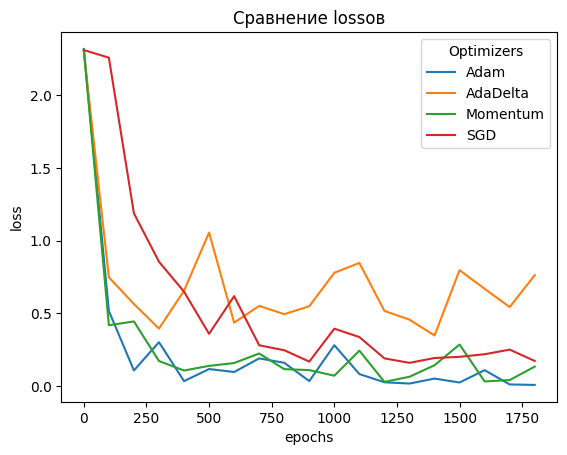

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, loss_adam, label = 'Adam')
ax.plot(x, loss_adadelta, label = 'AdaDelta')
ax.plot(x, loss_momentum, label = 'Momentum')
ax.plot(x, loss_sgd, label = 'SGD')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Сравнение lossов')

plt.legend(title='Optimizers')

plt.show()

В целом, все методы оптимизации, кроме Adadelta, показали ожидаемый результат.
Adadelta на первых эпохах сходилась также хорошо, как и остальные алгоритмы, но на последних эпохах дала точность даже хуже, чем SGD. Это может объясняться простотой сверточной НС.
Худшую точность показал обычный стохастический градиентный спуск, чуть лучшую Momentum. А лучше всех, как ожидалось, сошелся Adam